In [2]:
import sys, numpy, scipy, sklearn, joblib, librosa, lightgbm
    
print("Python   :", sys.version.split()[0])
print("NumPy    :", numpy.__version__)
print("SciPy    :", scipy.__version__)
print("sklearn  :", sklearn.__version__)
print("joblib   :", joblib.__version__)
print("librosa  :", librosa.__version__)
print("LightGBM :", lightgbm.__version__)


Python   : 3.11.13
NumPy    : 2.2.6
SciPy    : 1.16.1
sklearn  : 1.7.1
joblib   : 1.5.1
librosa  : 0.10.2.post1
LightGBM : 4.6.0


In [57]:
import numpy as np
import librosa
from pathlib import Path
from scipy.signal import butter, sosfiltfilt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

"""
Class Conditional Warmup + Tests
- Supports two frame-level normalization modes:
    1) env_warmed: Environment‑Warmed EMA‑CMVN (online style)
    2) cmvn_standard: Global per-file CMVN
- Provides both in-domain (group-aware split) and cross-domain (train dir → test dir) evaluation.
- Prints per-class counts and shapes.
"""

# --------------------- CONFIG ---------------------
DATA_DIR = "RPB1"   # training directory (set to e.g. "RP_56")
TEST_DIR = "RP11_mb"          # optional external test dir (set to None to skip)
PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}
SR, N_MFCC = 22050, 13
BP_LO, BP_HI = 400.0, 4000.0
EMA_ALPHA, MIN_VAR = 0.05, 1e-3
ENVIRONMENT_CLASS, RAND_SEED = 4, 1337
EPS = 1e-6

# --------------------- Utils ---------------------

def class_counts_str(y: np.ndarray) -> str:
    """Return a compact string of counts like "0:123 1:45 ..."""
    if y.size == 0:
        return "<empty>"
    u, c = np.unique(y, return_counts=True)
    return " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c))

# --------------------- DSP ---------------------

def pre_emphasis(x, coeff=0.97):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0:
        return x
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - coeff * x[:-1]
    return y


def _bp_sos(sr, lo, hi, order=4):
    nyq = 0.5 * sr
    lo_n, hi_n = max(1.0, lo) / nyq, min(hi, nyq - 1.0) / nyq
    if not (0.0 < lo_n < hi_n < 1.0):
        raise ValueError(f"Invalid band ({lo}, {hi}) for sr={sr}")
    return butter(order, [lo_n, hi_n], btype="band", output="sos")


def bandpass(x, sr, lo=BP_LO, hi=BP_HI):
    # guard for very short clips (filtfilt needs padding)
    if x.size < max(256, 3 * 4 * 2):  # ~ guard by order
        return x.astype(np.float32, copy=False)
    return sosfiltfilt(_bp_sos(sr, lo, hi), np.asarray(x, dtype=np.float32))

# --------------------- Env‑Warmed EMA‑CMVN ---------------------

class EnvWarmedCMVN:
    def __init__(self, alpha=EMA_ALPHA, min_var=MIN_VAR):
        self.alpha, self.min_var = float(alpha), float(min_var)
        self.mu = None
        self.var = None
        self.ready = False

    def warmup(self, mfcc_list):
        mfcc_list = [m for m in mfcc_list if m.ndim == 2 and m.size > 0]
        if not mfcc_list:
            return False
        env = np.concatenate(mfcc_list, axis=1).astype(np.float32)
        self.mu = env.mean(axis=1)
        self.var = np.maximum(env.var(axis=1), self.min_var)
        self.ready = True
        return True

    def normalize(self, M):
        if not self.ready:
            W = min(10, M.shape[1])
            self.mu = M[:, :W].mean(axis=1).astype(np.float32)
            self.var = np.maximum(M[:, :W].var(axis=1), self.min_var).astype(np.float32)
            self.ready = True
        mu = self.mu.astype(np.float32).copy()
        var = self.var.astype(np.float32).copy()
        out = np.empty_like(M, dtype=np.float32)
        for t in range(M.shape[1]):
            x = M[:, t].astype(np.float32)
            d = x - mu
            mu = mu + self.alpha * d
            # stable variance update around evolving mean
            var = (1.0 - self.alpha) * (var + self.alpha * (d * d))
            var = np.maximum(var, self.min_var)
            out[:, t] = (x - mu) / np.sqrt(var + EPS)
        return out

# --------------------- Global (per-file) CMVN ---------------------

def global_cmvn_frames(M):
    mu = M.mean(axis=1, keepdims=True)
    std = M.std(axis=1, keepdims=True)
    std = np.maximum(std, 1e-6)
    return (M - mu) / std

# --------------------- Feature Extraction ---------------------

def features_from_signal(y, sr, mode="env_warmed", env_norm: EnvWarmedCMVN | None = None):
    x = bandpass(pre_emphasis(y), sr)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=N_MFCC)

    if mode == "env_warmed":
        if env_norm is None:
            env_norm = EnvWarmedCMVN()
        M = env_norm.normalize(mfcc)
    elif mode == "cmvn_standard":
        M = global_cmvn_frames(mfcc)
    else:
        M = mfcc  # raw (no frame-level normalization)

    # compact summary features (4 * C)
    feat = np.concatenate([
        M.mean(axis=1),
        M.std(axis=1) + 1e-6,
        np.percentile(M, 25, axis=1),
        np.percentile(M, 75, axis=1),
    ]).astype(np.float32)
    return feat

# --------------------- Dataset builders ---------------------

def build_dataset(base_dir, patterns, mode="env_warmed"):
    env_norm = None
    if mode == "env_warmed":
        env_norm = EnvWarmedCMVN()
        env_mfcc = []
        for p in sorted(Path(base_dir).glob(patterns[ENVIRONMENT_CLASS])):
            y, _ = librosa.load(p, sr=SR, mono=True)
            if y.size < SR * 0.1:
                continue
            x = bandpass(pre_emphasis(y), SR)
            env_mfcc.append(librosa.feature.mfcc(y=x, sr=SR, n_mfcc=N_MFCC))
        if not env_norm.warmup(env_mfcc):
            print("[WARN] No env warmup data; will init from first frames.")

    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(Path(base_dir).glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True)
                if y.size < SR * 0.1:
                    continue
                feat = features_from_signal(y, SR, mode=mode, env_norm=env_norm)
                if np.any(~np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(Path(p).stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")
    return np.vstack(X), np.asarray(ys, int), np.asarray(groups)

# Cross-domain build using an existing env_norm (warmed on TRAIN ONLY)

def build_dataset_with_norm(base_dir, patterns, mode, env_norm: EnvWarmedCMVN | None):
    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(Path(base_dir).glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True)
                if y.size < SR * 0.1:
                    continue
                feat = features_from_signal(y, SR, mode=mode, env_norm=env_norm)
                if np.any(~np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(Path(p).stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")
    return np.vstack(X), np.asarray(ys, int), np.asarray(groups)

# --------------------- Evaluations ---------------------

def eval_in_domain(X, y, groups):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=RAND_SEED)
    tr, te = next(gss.split(X, y, groups))
    scaler = StandardScaler().fit(X[tr])
    clf = LogisticRegression(max_iter=1000, random_state=RAND_SEED)
    clf.fit(scaler.transform(X[tr]), y[tr])
    acc = clf.score(scaler.transform(X[te]), y[te])
    return acc, tr, te


def eval_cross_domain(train_dir, test_dir, mode):
    # Build train set (and capture env_norm if needed)
    env_norm = None
    if mode == "env_warmed":
        # warmup inside build_dataset
        Xtr, ytr, gtr = build_dataset(train_dir, PATTERNS, mode=mode)
        # Re-create env_norm warmed on TRAIN for reuse on TEST
        env_norm = EnvWarmedCMVN()
        env_mfcc = []
        for p in sorted(Path(train_dir).glob(PATTERNS[ENVIRONMENT_CLASS])):
            y, _ = librosa.load(p, sr=SR, mono=True)
            if y.size < SR * 0.1:
                continue
            x = bandpass(pre_emphasis(y), SR)
            env_mfcc.append(librosa.feature.mfcc(y=x, sr=SR, n_mfcc=N_MFCC))
        env_norm.warmup(env_mfcc)
    else:
        Xtr, ytr, gtr = build_dataset(train_dir, PATTERNS, mode=mode)

    # Build test set using the SAME normalization policy (no leakage)
    Xte, yte, gte = build_dataset_with_norm(test_dir, PATTERNS, mode, env_norm)

    scaler = StandardScaler().fit(Xtr)
    clf = LogisticRegression(max_iter=1000, random_state=RAND_SEED)
    clf.fit(scaler.transform(Xtr), ytr)
    acc = clf.score(scaler.transform(Xte), yte)
    return acc, Xtr, ytr, Xte, yte

# --------------------- Main ---------------------
if __name__ == "__main__":
    modes = ["cmvn_standard", "env_warmed","standard"]

    for mode in modes:
        print(f"== MODE: {mode}")
        # In-domain eval (single directory with group-aware split)
        X, y, groups = build_dataset(DATA_DIR, PATTERNS, mode=mode)
        print(f"All data shape: {X.shape} | class counts: {class_counts_str(y)}")
        acc_in, tr, te = eval_in_domain(X, y, groups)
        print(f"In-domain Acc[{mode}]: {acc_in:.4f}")
        print(f"  Train shape: {X[tr].shape} | class counts: {class_counts_str(y[tr])}")
        print(f"  Test  shape: {X[te].shape} | class counts: {class_counts_str(y[te])}")

        # Cross-domain eval (train on DATA_DIR, test on TEST_DIR)
        if TEST_DIR and Path(TEST_DIR).exists():
            acc_cd, Xtr, ytr, Xte, yte = eval_cross_domain(DATA_DIR, TEST_DIR, mode)
            print(f"Cross-domain Acc[{mode}] (train={DATA_DIR} → test={TEST_DIR}]): {acc_cd:.4f}")
            print(f"  Train shape: {Xtr.shape} | class counts: {class_counts_str(ytr)}")
            print(f"  Test  shape: {Xte.shape} | class counts: {class_counts_str(yte)}")
        else:
            print("(Skip cross-domain: TEST_DIR not set or not found)")


== MODE: cmvn_standard
All data shape: (758, 52) | class counts: 0:150 1:151 2:152 3:152 4:153
In-domain Acc[cmvn_standard]: 0.9167
  Train shape: (530, 52) | class counts: 0:99 1:93 2:104 3:121 4:113
  Test  shape: (228, 52) | class counts: 0:51 1:58 2:48 3:31 4:40
Cross-domain Acc[cmvn_standard] (train=RPB1 → test=RP11_mb]): 0.3990
  Train shape: (758, 52) | class counts: 0:150 1:151 2:152 3:152 4:153
  Test  shape: (579, 52) | class counts: 1:115 2:112 3:107 4:122 5:123
== MODE: env_warmed
All data shape: (758, 52) | class counts: 0:150 1:151 2:152 3:152 4:153
In-domain Acc[env_warmed]: 0.9737
  Train shape: (530, 52) | class counts: 0:99 1:93 2:104 3:121 4:113
  Test  shape: (228, 52) | class counts: 0:51 1:58 2:48 3:31 4:40
Cross-domain Acc[env_warmed] (train=RPB1 → test=RP11_mb]): 0.4750
  Train shape: (758, 52) | class counts: 0:150 1:151 2:152 3:152 4:153
  Test  shape: (579, 52) | class counts: 1:115 2:112 3:107 4:122 5:123
== MODE: standard
All data shape: (758, 52) | class c

In [ ]:
import os
import numpy as np
import librosa
from pathlib import Path
from scipy.signal import butter, sosfiltfilt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

"""
Class Conditional Warmup + Tests (+ t-SNE)
- Frame-level normalization modes:
    1) env_warmed: Environment‑Warmed EMA‑CMVN (online style)
    2) cmvn_standard: Global per-file CMVN
- In-domain (group-aware split) + Cross-domain (train dir → test dir)
- Prints per-class counts and shapes.
- NEW: Saves t-SNE plots for train/test splits (in-domain & cross-domain) to ./tsne_plots
"""

# --------------------- CONFIG ---------------------
DATA_DIR = "RPB1"          # training directory
TEST_DIR = "all_tester"    # external test dir (set to None or non-existent to skip)
PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}
SR, N_MFCC = 22050, 13
BP_LO, BP_HI = 400.0, 4000.0
EMA_ALPHA, MIN_VAR = 0.05, 1e-3
ENVIRONMENT_CLASS, RAND_SEED = 4, 1337
EPS = 1e-6
OUT_TSNE_DIR = Path("tsne_plots"); OUT_TSNE_DIR.mkdir(parents=True, exist_ok=True)

# --------------------- Utils ---------------------

def class_counts_str(y: np.ndarray) -> str:
    if y.size == 0:
        return "<empty>"
    u, c = np.unique(y, return_counts=True)
    return " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c))

# --------------------- DSP ---------------------

def pre_emphasis(x, coeff=0.97):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0:
        return x
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - coeff * x[:-1]
    return y


def _bp_sos(sr, lo, hi, order=4):
    nyq = 0.5 * sr
    lo_n, hi_n = max(1.0, lo) / nyq, min(hi, nyq - 1.0) / nyq
    if not (0.0 < lo_n < hi_n < 1.0):
        raise ValueError(f"Invalid band ({lo}, {hi}) for sr={sr}")
    return butter(order, [lo_n, hi_n], btype="band", output="sos")


def bandpass(x, sr, lo=BP_LO, hi=BP_HI):
    if x.size < max(256, 3 * 4 * 2):  # ~ guard by order
        return x.astype(np.float32, copy=False)
    return sosfiltfilt(_bp_sos(sr, lo, hi), np.asarray(x, dtype=np.float32))

# --------------------- Env‑Warmed EMA‑CMVN ---------------------

class EnvWarmedCMVN:
    def __init__(self, alpha=EMA_ALPHA, min_var=MIN_VAR):
        self.alpha, self.min_var = float(alpha), float(min_var)
        self.mu = None
        self.var = None
        self.ready = False

    def warmup(self, mfcc_list):
        mfcc_list = [m for m in mfcc_list if m.ndim == 2 and m.size > 0]
        if not mfcc_list:
            return False
        env = np.concatenate(mfcc_list, axis=1).astype(np.float32)
        self.mu = env.mean(axis=1)
        self.var = np.maximum(env.var(axis=1), self.min_var)
        self.ready = True
        return True

    def normalize(self, M):
        if not self.ready:
            W = min(10, M.shape[1])
            self.mu = M[:, :W].mean(axis=1).astype(np.float32)
            self.var = np.maximum(M[:, :W].var(axis=1), self.min_var).astype(np.float32)
            self.ready = True
        mu = self.mu.astype(np.float32).copy()
        var = self.var.astype(np.float32).copy()
        out = np.empty_like(M, dtype=np.float32)
        for t in range(M.shape[1]):
            x = M[:, t].astype(np.float32)
            d = x - mu
            mu = mu + self.alpha * d
            var = (1.0 - self.alpha) * (var + self.alpha * (d * d))
            var = np.maximum(var, self.min_var)
            out[:, t] = (x - mu) / np.sqrt(var + EPS)
        return out

# --------------------- Global (per-file) CMVN ---------------------

def global_cmvn_frames(M):
    mu = M.mean(axis=1, keepdims=True)
    std = M.std(axis=1, keepdims=True)
    std = np.maximum(std, 1e-6)
    return (M - mu) / std

# --------------------- Feature Extraction ---------------------

def features_from_signal(y, sr, mode="env_warmed", env_norm: EnvWarmedCMVN | None = None):
    x = bandpass(pre_emphasis(y), sr)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=N_MFCC)

    if mode == "env_warmed":
        if env_norm is None:
            env_norm = EnvWarmedCMVN()
        M = env_norm.normalize(mfcc)
    elif mode == "cmvn_standard":
        M = global_cmvn_frames(mfcc)
    else:
        M = mfcc

    feat = np.concatenate([
        M.mean(axis=1),
        M.std(axis=1) + 1e-6,
        np.percentile(M, 25, axis=1),
        np.percentile(M, 75, axis=1),
    ]).astype(np.float32)
    return feat

# --------------------- Dataset builders ---------------------

def build_dataset(base_dir, patterns, mode="env_warmed"):
    env_norm = None
    if mode == "env_warmed":
        env_norm = EnvWarmedCMVN()
        env_mfcc = []
        for p in sorted(Path(base_dir).glob(patterns[ENVIRONMENT_CLASS])):
            y, _ = librosa.load(p, sr=SR, mono=True)
            if y.size < SR * 0.1:
                continue
            x = bandpass(pre_emphasis(y), SR)
            env_mfcc.append(librosa.feature.mfcc(y=x, sr=SR, n_mfcc=N_MFCC))
        if not env_norm.warmup(env_mfcc):
            print("[WARN] No env warmup data; will init from first frames.")

    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(Path(base_dir).glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True)
                if y.size < SR * 0.1:
                    continue
                feat = features_from_signal(y, SR, mode=mode, env_norm=env_norm)
                if np.any(~np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(Path(p).stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")
    return np.vstack(X), np.asarray(ys, int), np.asarray(groups)

# Cross-domain build using an existing env_norm (warmed on TRAIN ONLY)

def build_dataset_with_norm(base_dir, patterns, mode, env_norm: EnvWarmedCMVN | None):
    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(Path(base_dir).glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True)
                if y.size < SR * 0.1:
                    continue
                feat = features_from_signal(y, SR, mode=mode, env_norm=env_norm)
                if np.any(~np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(Path(p).stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")
    return np.vstack(X), np.asarray(ys, int), np.asarray(groups)

# --------------------- t-SNE helpers ---------------------

def _choose_perplexity(n: int) -> int:
    # typical safe range [5..50]; choose based on n
    return int(max(5, min(30, (n - 1) // 3)))


def tsne_embed(X: np.ndarray, random_state: int = RAND_SEED) -> np.ndarray:
    n = X.shape[0]
    perplexity = _choose_perplexity(n)
    tsne = TSNE(n_components=2, perplexity=perplexity, init="pca",
                learning_rate="auto", random_state=random_state)
    return tsne.fit_transform(X)


def plot_tsne_split(Xtr: np.ndarray, ytr: np.ndarray, Xte: np.ndarray, yte: np.ndarray,
                    title: str, out_path: Path):
    X_all = np.vstack([Xtr, Xte])
    y_all = np.concatenate([ytr, yte])
    Z = tsne_embed(X_all)
    Ztr, Zte = Z[: len(ytr)], Z[len(ytr):]

    plt.figure(figsize=(7, 6))
    classes = np.unique(y_all)
    # Plot train (circle) & test (triangle) per class for clarity
    for c in classes:
        m_tr = ytr == c
        m_te = yte == c
        plt.scatter(Ztr[m_tr, 0], Ztr[m_tr, 1], s=18, label=f"train c{c}", alpha=0.7)
        plt.scatter(Zte[m_te, 0], Zte[m_te, 1], s=28, marker='^', label=f"test c{c}", alpha=0.8)
    plt.title(title)
    plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
    plt.legend(loc='best', fontsize=8, ncol=2)
    plt.tight_layout()
    plt.savefig(out_path, dpi=160)
    plt.close()
    print(f"[t-SNE] saved → {out_path}")

# --------------------- Evaluations ---------------------

def eval_in_domain(X, y, groups):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=RAND_SEED)
    tr, te = next(gss.split(X, y, groups))
    scaler = StandardScaler().fit(X[tr])
    Xtr_s, Xte_s = scaler.transform(X[tr]), scaler.transform(X[te])

    # t-SNE plot (joint train+test)
    plot_tsne_split(Xtr_s, y[tr], Xte_s, y[te],
                    title=f"t-SNE In-domain ({DATA_DIR})",
                    out_path=OUT_TSNE_DIR / f"tsne_indomain_{DATA_DIR}.png")

    clf = LogisticRegression(max_iter=1000, random_state=RAND_SEED)
    clf.fit(Xtr_s, y[tr])
    acc = clf.score(Xte_s, y[te])
    return acc, tr, te


def eval_cross_domain(train_dir, test_dir, mode):
    env_norm = None
    if mode == "env_warmed":
        Xtr, ytr, gtr = build_dataset(train_dir, PATTERNS, mode=mode)
        env_norm = EnvWarmedCMVN()
        env_mfcc = []
        for p in sorted(Path(train_dir).glob(PATTERNS[ENVIRONMENT_CLASS])):
            y, _ = librosa.load(p, sr=SR, mono=True)
            if y.size < SR * 0.1:
                continue
            x = bandpass(pre_emphasis(y), SR)
            env_mfcc.append(librosa.feature.mfcc(y=x, sr=SR, n_mfcc=N_MFCC))
        env_norm.warmup(env_mfcc)
    else:
        Xtr, ytr, gtr = build_dataset(train_dir, PATTERNS, mode=mode)

    Xte, yte, gte = build_dataset_with_norm(test_dir, PATTERNS, mode, env_norm)

    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

    # t-SNE plot (joint train+test, cross-domain)
    plot_tsne_split(Xtr_s, ytr, Xte_s, yte,
                    title=f"t-SNE Cross-domain ({train_dir} → {test_dir})",
                    out_path=OUT_TSNE_DIR / f"tsne_cross_{train_dir}_to_{test_dir}.png")

    clf = LogisticRegression(max_iter=1000, random_state=RAND_SEED)
    clf.fit(Xtr_s, ytr)
    acc = clf.score(Xte_s, yte)
    return acc, Xtr, ytr, Xte, yte

# --------------------- Main ---------------------
import os
import numpy as np
import librosa
from pathlib import Path
from scipy.signal import butter, sosfiltfilt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import json

"""
Class Conditional Warmup + Tests (+ t-SNE)
- Frame-level normalization modes:
    1) env_warmed: Environment‑Warmed EMA‑CMVN (online style)
    2) cmvn_standard: Global per-file CMVN
- In-domain (group-aware split) + Cross-domain (train dir → test dir)
- Prints per-class counts and shapes.
- NEW: Saves t-SNE plots for train/test splits (in-domain & cross-domain) to ./tsne_plots
"""

# --------------------- CONFIG ---------------------
DATA_DIR = "RPB1"          # training directory
TEST_DIR = "all_tester"    # external test dir (set to None or non-existent to skip)
PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}
SR, N_MFCC = 22050, 13
BP_LO, BP_HI = 400.0, 4000.0
EMA_ALPHA, MIN_VAR = 0.05, 1e-3
ENVIRONMENT_CLASS, RAND_SEED = 4, 1337
EPS = 1e-6
OUT_TSNE_DIR = Path("tsne_plots"); OUT_TSNE_DIR.mkdir(parents=True, exist_ok=True)

# --------------------- Utils ---------------------

def class_counts_str(y: np.ndarray) -> str:
    if y.size == 0:
        return "<empty>"
    u, c = np.unique(y, return_counts=True)
    return " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c))

# --------------------- DSP ---------------------

def pre_emphasis(x, coeff=0.97):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0:
        return x
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - coeff * x[:-1]
    return y


def _bp_sos(sr, lo, hi, order=4):
    nyq = 0.5 * sr
    lo_n, hi_n = max(1.0, lo) / nyq, min(hi, nyq - 1.0) / nyq
    if not (0.0 < lo_n < hi_n < 1.0):
        raise ValueError(f"Invalid band ({lo}, {hi}) for sr={sr}")
    return butter(order, [lo_n, hi_n], btype="band", output="sos")


def bandpass(x, sr, lo=BP_LO, hi=BP_HI):
    if x.size < max(256, 3 * 4 * 2):  # ~ guard by order
        return x.astype(np.float32, copy=False)
    return sosfiltfilt(_bp_sos(sr, lo, hi), np.asarray(x, dtype=np.float32))

# --------------------- Env‑Warmed EMA‑CMVN ---------------------

class EnvWarmedCMVN:
    def __init__(self, alpha=EMA_ALPHA, min_var=MIN_VAR):
        self.alpha, self.min_var = float(alpha), float(min_var)
        self.mu = None
        self.var = None
        self.ready = False

    def warmup(self, mfcc_list):
        mfcc_list = [m for m in mfcc_list if m.ndim == 2 and m.size > 0]
        if not mfcc_list:
            return False
        env = np.concatenate(mfcc_list, axis=1).astype(np.float32)
        self.mu = env.mean(axis=1)
        self.var = np.maximum(env.var(axis=1), self.min_var)
        self.ready = True
        return True

    def normalize(self, M):
        if not self.ready:
            W = min(10, M.shape[1])
            self.mu = M[:, :W].mean(axis=1).astype(np.float32)
            self.var = np.maximum(M[:, :W].var(axis=1), self.min_var).astype(np.float32)
            self.ready = True
        mu = self.mu.astype(np.float32).copy()
        var = self.var.astype(np.float32).copy()
        out = np.empty_like(M, dtype=np.float32)
        for t in range(M.shape[1]):
            x = M[:, t].astype(np.float32)
            d = x - mu
            mu = mu + self.alpha * d
            var = (1.0 - self.alpha) * (var + self.alpha * (d * d))
            var = np.maximum(var, self.min_var)
            out[:, t] = (x - mu) / np.sqrt(var + EPS)
        return out

# --------------------- Global (per-file) CMVN ---------------------

def global_cmvn_frames(M):
    mu = M.mean(axis=1, keepdims=True)
    std = M.std(axis=1, keepdims=True)
    std = np.maximum(std, 1e-6)
    return (M - mu) / std

# --------------------- Feature Extraction ---------------------

def features_from_signal(y, sr, mode="env_warmed", env_norm: EnvWarmedCMVN | None = None):
    x = bandpass(pre_emphasis(y), sr)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=N_MFCC)

    if mode == "env_warmed":
        if env_norm is None:
            env_norm = EnvWarmedCMVN()
        M = env_norm.normalize(mfcc)
    elif mode == "cmvn_standard":
        M = global_cmvn_frames(mfcc)
    else:
        M = mfcc

    feat = np.concatenate([
        M.mean(axis=1),
        M.std(axis=1) + 1e-6,
        np.percentile(M, 25, axis=1),
        np.percentile(M, 75, axis=1),
    ]).astype(np.float32)
    return feat

# --------------------- Dataset builders ---------------------

def build_dataset(base_dir, patterns, mode="env_warmed"):
    env_norm = None
    if mode == "env_warmed":
        env_norm = EnvWarmedCMVN()
        env_mfcc = []
        for p in sorted(Path(base_dir).glob(patterns[ENVIRONMENT_CLASS])):
            y, _ = librosa.load(p, sr=SR, mono=True)
            if y.size < SR * 0.1:
                continue
            x = bandpass(pre_emphasis(y), SR)
            env_mfcc.append(librosa.feature.mfcc(y=x, sr=SR, n_mfcc=N_MFCC))
        if not env_norm.warmup(env_mfcc):
            print("[WARN] No env warmup data; will init from first frames.")

    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(Path(base_dir).glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True)
                if y.size < SR * 0.1:
                    continue
                feat = features_from_signal(y, SR, mode=mode, env_norm=env_norm)
                if np.any(~np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(Path(p).stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")
    return np.vstack(X), np.asarray(ys, int), np.asarray(groups)

# Cross-domain build using an existing env_norm (warmed on TRAIN ONLY)

def build_dataset_with_norm(base_dir, patterns, mode, env_norm: EnvWarmedCMVN | None):
    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(Path(base_dir).glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True)
                if y.size < SR * 0.1:
                    continue
                feat = features_from_signal(y, SR, mode=mode, env_norm=env_norm)
                if np.any(~np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(Path(p).stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")
    return np.vstack(X), np.asarray(ys, int), np.asarray(groups)

# --------------------- t-SNE helpers ---------------------

def _choose_perplexity(n: int) -> int:
    # typical safe range [5..50]; choose based on n
    return int(max(5, min(30, (n - 1) // 3)))


def tsne_embed(X: np.ndarray, random_state: int = RAND_SEED) -> np.ndarray:
    n = X.shape[0]
    perplexity = _choose_perplexity(n)
    tsne = TSNE(n_components=2, perplexity=perplexity, init="pca",
                learning_rate="auto", random_state=random_state)
    return tsne.fit_transform(X)


def plot_tsne_split(Xtr: np.ndarray, ytr: np.ndarray, Xte: np.ndarray, yte: np.ndarray,
                    title: str, out_path: Path):
    X_all = np.vstack([Xtr, Xte])
    y_all = np.concatenate([ytr, yte])
    Z = tsne_embed(X_all)
    Ztr, Zte = Z[: len(ytr)], Z[len(ytr):]

    plt.figure(figsize=(7, 6))
    classes = np.unique(y_all)
    # Plot train (circle) & test (triangle) per class for clarity
    for c in classes:
        m_tr = ytr == c
        m_te = yte == c
        plt.scatter(Ztr[m_tr, 0], Ztr[m_tr, 1], s=18, label=f"train c{c}", alpha=0.7)
        plt.scatter(Zte[m_te, 0], Zte[m_te, 1], s=28, marker='^', label=f"test c{c}", alpha=0.8)
    plt.title(title)
    plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
    plt.legend(loc='best', fontsize=8, ncol=2)
    plt.tight_layout()
    plt.savefig(out_path, dpi=160)
    plt.close()
    print(f"[t-SNE] saved → {out_path}")

# --------------------- Evaluations ---------------------

def eval_in_domain(X, y, groups):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=RAND_SEED)
    tr, te = next(gss.split(X, y, groups))
    scaler = StandardScaler().fit(X[tr])
    Xtr_s, Xte_s = scaler.transform(X[tr]), scaler.transform(X[te])

    # t-SNE plot (joint train+test)
    plot_tsne_split(Xtr_s, y[tr], Xte_s, y[te],
                    title=f"t-SNE In-domain ({DATA_DIR})",
                    out_path=OUT_TSNE_DIR / f"tsne_indomain_{DATA_DIR}.png")

    clf = LogisticRegression(max_iter=1000, random_state=RAND_SEED)
    clf.fit(Xtr_s, y[tr])
    acc = clf.score(Xte_s, y[te])
    return acc, tr, te


def eval_cross_domain(train_dir, test_dir, mode):
    env_norm = None
    if mode == "env_warmed":
        Xtr, ytr, gtr = build_dataset(train_dir, PATTERNS, mode=mode)
        env_norm = EnvWarmedCMVN()
        env_mfcc = []
        for p in sorted(Path(train_dir).glob(PATTERNS[ENVIRONMENT_CLASS])):
            y, _ = librosa.load(p, sr=SR, mono=True)
            if y.size < SR * 0.1:
                continue
            x = bandpass(pre_emphasis(y), SR)
            env_mfcc.append(librosa.feature.mfcc(y=x, sr=SR, n_mfcc=N_MFCC))
        env_norm.warmup(env_mfcc)
    else:
        Xtr, ytr, gtr = build_dataset(train_dir, PATTERNS, mode=mode)

    Xte, yte, gte = build_dataset_with_norm(test_dir, PATTERNS, mode, env_norm)

    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xte)

    # t-SNE plot (joint train+test, cross-domain)
    plot_tsne_split(Xtr_s, ytr, Xte_s, yte,
                    title=f"t-SNE Cross-domain ({train_dir} → {test_dir})",
                    out_path=OUT_TSNE_DIR / f"tsne_cross_{train_dir}_to_{test_dir}.png")

    clf = LogisticRegression(max_iter=1000, random_state=RAND_SEED)
    clf.fit(Xtr_s, ytr)
    acc = clf.score(Xte_s, yte)
    return acc, Xtr, ytr, Xte, yte

# --------------------- Main ---------------------
if __name__ == "__main__":
    modes = ["cmvn_standard", "env_warmed", "standard"]

    # --- collect results in 3 variables ---
    results_in = {}      # per-mode in-domain metrics
    results_cross = {}   # per-mode cross-domain metrics (if TEST_DIR exists)
    results_meta = {}    # per-mode meta info (shapes / overall counts)

    for mode in modes:
        print(f"\n== MODE: {mode}")
        # In-domain eval
        X, y, groups = build_dataset(DATA_DIR, PATTERNS, mode=mode)
        all_counts = class_counts_str(y)
        print(f"All data shape: {X.shape} | class counts: {all_counts}")
        acc_in, tr, te = eval_in_domain(X, y, groups)
        print(f"In-domain Acc[{mode}]: {acc_in:.4f}")
        train_counts = class_counts_str(y[tr])
        test_counts  = class_counts_str(y[te])
        print(f"  Train shape: {X[tr].shape} | class counts: {train_counts}")
        print(f"  Test  shape: {X[te].shape} | class counts: {test_counts}")

        # store in-domain
        results_in[mode] = {
            "acc": float(acc_in),
            "train_shape": list(X[tr].shape),
            "test_shape": list(X[te].shape),
            "class_counts_train": train_counts,
            "class_counts_test": test_counts,
        }
        results_meta[mode] = {
            "all_shape": list(X.shape),
            "class_counts_all": all_counts,
        }

        # Cross-domain eval
        if TEST_DIR and Path(TEST_DIR).exists():
            acc_cd, Xtr, ytr, Xte, yte = eval_cross_domain(DATA_DIR, TEST_DIR, mode)
            print(f"Cross-domain Acc[{mode}] (train={DATA_DIR} → test={TEST_DIR}]): {acc_cd:.4f}")
            tr_counts = class_counts_str(ytr)
            te_counts = class_counts_str(yte)
            print(f"  Train shape: {Xtr.shape} | class counts: {tr_counts}")
            print(f"  Test  shape: {Xte.shape} | class counts: {te_counts}")
            results_cross[mode] = {
                "acc": float(acc_cd),
                "train_shape": list(Xtr.shape),
                "test_shape": list(Xte.shape),
                "class_counts_train": tr_counts,
                "class_counts_test": te_counts,
            }
        else:
            print("(Skip cross-domain: TEST_DIR not set or not found)")
            results_cross[mode] = None

    # Save summaries (single JSON)
    summary = {
        "in_domain": results_in,
        "cross_domain": results_cross,
        "meta": results_meta,
        "config": {"DATA_DIR": DATA_DIR, "TEST_DIR": TEST_DIR, "modes": modes},
    }
    out_json = Path("results_summary.json")
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)
    print(f"\n[Saved] summary → {out_json}")



== MODE: cmvn_standard
All data shape: (758, 52) | class counts: 0:150 1:151 2:152 3:152 4:153
[t-SNE] saved → tsne_plots\tsne_indomain_RPB1.png
In-domain Acc[cmvn_standard]: 0.9167
  Train shape: (530, 52) | class counts: 0:99 1:93 2:104 3:121 4:113
  Test  shape: (228, 52) | class counts: 0:51 1:58 2:48 3:31 4:40
[t-SNE] saved → tsne_plots\tsne_cross_RPB1_to_all_tester.png
Cross-domain Acc[cmvn_standard] (train=RPB1 → test=all_tester]): 0.5525
  Train shape: (758, 52) | class counts: 0:150 1:151 2:152 3:152 4:153
  Test  shape: (2751, 52) | class counts: 0:482 1:654 2:658 3:476 4:275 5:206

== MODE: env_warmed
All data shape: (758, 52) | class counts: 0:150 1:151 2:152 3:152 4:153
[t-SNE] saved → tsne_plots\tsne_indomain_RPB1.png
In-domain Acc[env_warmed]: 0.9737
  Train shape: (530, 52) | class counts: 0:99 1:93 2:104 3:121 4:113
  Test  shape: (228, 52) | class counts: 0:51 1:58 2:48 3:31 4:40
[t-SNE] saved → tsne_plots\tsne_cross_RPB1_to_all_tester.png
Cross-domain Acc[env_warmed

In [141]:
import numpy as np
import librosa
from pathlib import Path
from scipy.signal import butter, sosfiltfilt

# --------------------- CONFIG ---------------------
DATA_DIR = "all_tester"
PATTERNS = {
    0: "mast_2025*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav",
}
SR, N_MFCC = 22050, 30
BP_LO, BP_HI = 400.0, 4000.0
EMA_ALPHA, MIN_VAR = 0.05, 1e-3
ENVIRONMENT_CLASS = 4
EPS = 1e-6

# --------------------- DSP ---------------------
def pre_emphasis(x, coeff=0.97):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0: return x
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - coeff * x[:-1]
    return y

def _bp_sos(sr, lo, hi, order=4):
    nyq = 0.5 * sr
    lo_n, hi_n = max(1.0, lo) / nyq, min(hi, nyq - 1.0) / nyq
    if not (0.0 < lo_n < hi_n < 1.0):
        raise ValueError(f"Invalid band ({lo}, {hi}) for sr={sr}")
    return butter(order, [lo_n, hi_n], btype="band", output="sos")

def bandpass(x, sr, lo=BP_LO, hi=BP_HI):
    if x.size < max(256, 3 * 4 * 2):
        return x.astype(np.float32, copy=False)
    return sosfiltfilt(_bp_sos(sr, lo, hi), np.asarray(x, dtype=np.float32))

# --------------------- Env-Warmed EMA-CMVN ---------------------
class EnvWarmedCMVN:
    def __init__(self, alpha=EMA_ALPHA, min_var=MIN_VAR):
        self.alpha = float(alpha)
        self.min_var = float(min_var)
        self.mu = None
        self.var = None
        self.ready = False

    def warmup(self, mfcc_list):
        mfcc_list = [m for m in mfcc_list if m.ndim == 2 and m.size > 0]
        if not mfcc_list:
            return False
        env = np.concatenate(mfcc_list, axis=1).astype(np.float32)
        self.mu = env.mean(axis=1)
        self.var = np.maximum(env.var(axis=1), self.min_var)
        self.ready = True
        return True

    def normalize(self, M):
        if not self.ready:
            W = min(10, M.shape[1])
            self.mu = M[:, :W].mean(axis=1).astype(np.float32)
            self.var = np.maximum(M[:, :W].var(axis=1), self.min_var).astype(np.float32)
            self.ready = True
        mu = self.mu.astype(np.float32).copy()
        var = self.var.astype(np.float32).copy()
        out = np.empty_like(M, dtype=np.float32)
        for t in range(M.shape[1]):
            x = M[:, t].astype(np.float32)
            d = x - mu
            mu = mu + self.alpha * d
            var = (1.0 - self.alpha) * (var + self.alpha * (d * d))
            var = np.maximum(var, self.min_var)
            out[:, t] = (x - mu) / np.sqrt(var + EPS)
        return out

# --------------------- Feature Extraction (EMA-CMVN only) ---------------------
def features_from_signal(y, sr, env_norm: EnvWarmedCMVN):
    x = bandpass(pre_emphasis(y), sr)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=N_MFCC)
    M = env_norm.normalize(mfcc)
    feat = np.concatenate([
        M.mean(axis=1),
        M.std(axis=1) + 1e-6,
        np.percentile(M, 25, axis=1),
        np.percentile(M, 75, axis=1),
    ]).astype(np.float32)
    return feat  # shape = (4 * N_MFCC,)

# --------------------- Build Dataset (single directory) ---------------------
def build_dataset(base_dir: str | Path, patterns: dict[int, str]):
    """
    Build dataset using Env-Warmed EMA-CMVN.
    1) อุ่นตัว normalizer จากไฟล์ environment_* ในโฟลเดอร์เดียวกัน
    2) ดึงฟีเจอร์ของทุกคลาสด้วย normalizer เดียวกัน
    Return:
        X:  (N, 4*N_MFCC) float32
        y:  (N,) int
        groups: (N,) str  (ใช้ stem ของไฟล์)
    """
    base_dir = Path(base_dir)
    env_norm = EnvWarmedCMVN()
    env_mfcc = []
    # Warm from environment clips
    for p in sorted(base_dir.glob(patterns[ENVIRONMENT_CLASS])):
        y, _ = librosa.load(p, sr=SR, mono=True)
        if y.size < SR * 0.1:  # skip <0.1s
            continue
        x = bandpass(pre_emphasis(y), SR)
        env_mfcc.append(librosa.feature.mfcc(y=x, sr=SR, n_mfcc=N_MFCC))
    if not env_norm.warmup(env_mfcc):
        print("[WARN] No env warmup data; will init from first frames on first clip.")

    X, ys, groups = [], [], []
    for label, pattern in patterns.items():
        for p in sorted(base_dir.glob(pattern)):
            try:
                y, _ = librosa.load(p, sr=SR, mono=True)
                if y.size < SR * 0.1:
                    continue
                feat = features_from_signal(y, SR, env_norm)
                if np.any(~np.isfinite(feat)):
                    continue
                X.append(feat); ys.append(label); groups.append(p.stem)
            except Exception as e:
                print(f"[WARN] skip {p}: {e}")

    if not X:
        return (np.empty((0, 4 * N_MFCC), dtype=np.float32),
                np.asarray([], dtype=int),
                np.asarray([], dtype=str))
    return np.vstack(X), np.asarray(ys, dtype=int), np.asarray(groups, dtype=str)

# --------------------- Minimal demo ---------------------
if __name__ == "__main__":
    X, y, groups = build_dataset(DATA_DIR, PATTERNS)
    print("X:", X.shape, "| y:", y.shape, "| groups:", groups.shape)
    if y.size:
        u, c = np.unique(y, return_counts=True)
        print("class counts:", " ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c)))


X: (2751, 120) | y: (2751,) | groups: (2751,)
class counts: 0:482 1:654 2:658 3:476 4:275 5:206


ทั้งหมด: 2751
ใกล้ environment (≤ R_env=25.053) : 163
outlier (Tukey per-class): 51
คงไว้: 2585 | ลบ: 166
บันทึกไฟล์: tsne_flags.csv


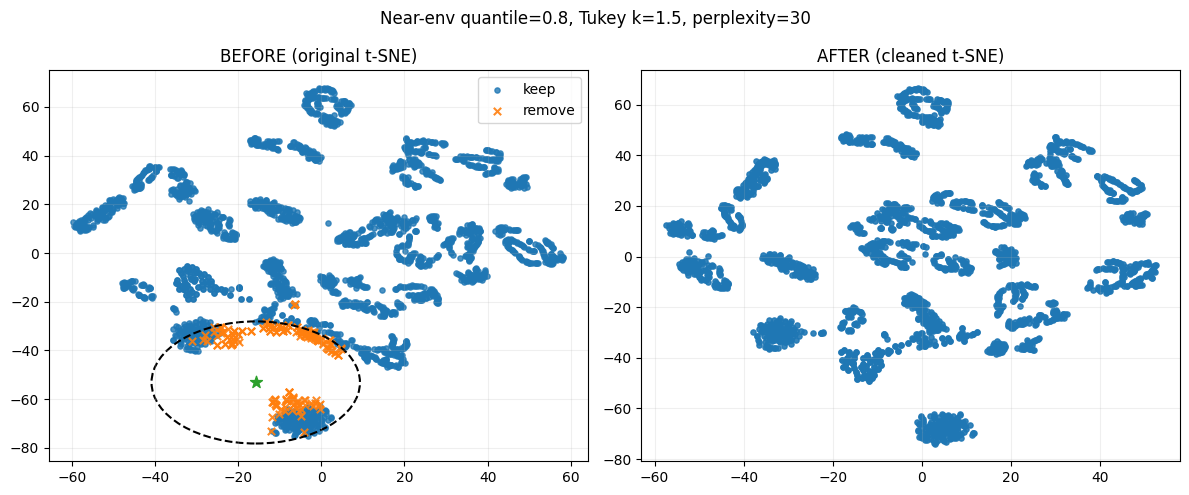

X_clean, y_clean, groups_clean พร้อมใช้งานแล้ว


In [142]:
# ===================== t-SNE cleaning: near-environment & outliers =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Circle

# ---------- Hyperparams (ปรับได้) ----------
RAND = 1337
R_ENV_QUANTILE = 0.80   # เลือก quantile ของรัศมีคลาส environment (เช่น 0.90 หรือ 0.95)
IQR_K = 1.5             # Tukey fence สำหรับหาจุด outlier ต่อคลาส
PERPLEXITY = None       # ถ้า None จะตั้งอัตโนมัติตามขนาดข้อมูล
RECOMPUTE_TSNE_AFTER = True  # หลังลบ คำนวณ t-SNE ใหม่เพื่อ plot "after"

# ---------- เตรียม ----------
assert 'X' in globals() and 'y' in globals() and 'groups' in globals(), \
    "ต้องรันเซล build_dataset ให้ได้ X,y,groups ก่อน"
assert 'ENVIRONMENT_CLASS' in globals(), "ต้องมี ENVIRONMENT_CLASS ก่อน (ค่า=4 ในโค้ดก่อนหน้า)"

N = X.shape[0]
if N < 5:
    raise ValueError("ตัวอย่างน้อยเกินไปสำหรับ t-SNE")

# scale ก่อนเพื่อความเสถียร
scaler_tsne = StandardScaler().fit(X)
Xn = scaler_tsne.transform(X)

# ตั้ง perplexity อัตโนมัติถ้าไม่ได้ระบุ
if PERPLEXITY is None:
    PERPLEXITY = int(np.clip(N // 50, 5, 30))

tsne = TSNE(
    n_components=2, init="pca", learning_rate="auto",
    perplexity=PERPLEXITY, random_state=RAND, verbose=0
)
Z = tsne.fit_transform(Xn)   # (N,2)

# ---------- หา "จุดที่เข้าใกล้ environment" ----------
is_env = (y == ENVIRONMENT_CLASS)
if np.sum(is_env) == 0:
    print("[WARN] ไม่พบตัวอย่าง environment — จะข้ามขั้นตอน near-environment")
    near_env_mask = np.zeros(N, dtype=bool)
    R_env = np.nan
    env_centroid = np.array([np.nan, np.nan])
else:
    Ze = Z[is_env]
    env_centroid = Ze.mean(axis=0)
    dist_env_env = np.linalg.norm(Ze - env_centroid, axis=1)
    # รัศมีของคลาส environment ตาม quantile
    R_env = np.quantile(dist_env_env, R_ENV_QUANTILE)
    # จุดที่ไม่ใช่ env แต่เข้าใกล้ centroid ภายในรัศมี R_env
    dist_to_env_centroid = np.linalg.norm(Z - env_centroid, axis=1)
    near_env_mask = (~is_env) & (dist_to_env_centroid <= R_env)

# ---------- หา outlier ต่อคลาส ด้วย Tukey fence บนระยะ centroid ----------
outlier_mask = np.zeros(N, dtype=bool)
for cls in np.unique(y):
    idx = np.where(y == cls)[0]
    Zc = Z[idx]
    ccent = Zc.mean(axis=0)
    dist_c = np.linalg.norm(Zc - ccent, axis=1)
    q1, q3 = np.percentile(dist_c, [25, 75])
    iqr = q3 - q1
    thr = q3 + IQR_K * iqr
    outlier_mask[idx] = dist_c > thr

# ---------- รวมกฎ ----------
remove_mask = near_env_mask | outlier_mask
keep_mask = ~remove_mask

print(f"ทั้งหมด: {N}")
print(f"ใกล้ environment (≤ R_env={R_env:.3f}) : {near_env_mask.sum()}")
print(f"outlier (Tukey per-class): {outlier_mask.sum()}")
print(f"คงไว้: {keep_mask.sum()} | ลบ: {remove_mask.sum()}")

# ---------- สร้าง DataFrame log ----------
log_df = pd.DataFrame({
    "idx": np.arange(N),
    "label": y,
    "group": groups,
    "z1": Z[:,0],
    "z2": Z[:,1],
    "flag_near_env": near_env_mask,
    "flag_outlier": outlier_mask,
    "remove": remove_mask,
})
if np.sum(is_env) > 0:
    log_df["dist_to_env_centroid"] = np.linalg.norm(Z - env_centroid, axis=1)
    log_df["R_env"] = R_env

log_df.to_csv("tsne_flags.csv", index=False)
print("บันทึกไฟล์: tsne_flags.csv")

# ---------- ลบออกจากข้อมูล ----------
X_clean = X[keep_mask]
y_clean = y[keep_mask]
groups_clean = groups[keep_mask]

# ---------- Plot: BEFORE / AFTER ----------
def _plot_before_after(Z_all, y_all, rm_mask, env_cent=None, R=None, title=""):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    # BEFORE
    ax[0].scatter(Z_all[~rm_mask,0], Z_all[~rm_mask,1], s=14, alpha=0.8, label="keep")
    ax[0].scatter(Z_all[rm_mask,0],  Z_all[rm_mask,1],  s=28, alpha=0.9, marker="x", label="remove")
    ax[0].set_title("BEFORE (original t-SNE)")
    ax[0].grid(True, alpha=0.2)
    ax[0].legend()
    if np.sum(is_env) > 0:
        ax[0].scatter([env_cent[0]], [env_cent[1]], s=80, marker="*", label="env centroid")
        circ = Circle(env_cent, R, fill=False, linewidth=1.5, linestyle="--")
        ax[0].add_patch(circ)

    # AFTER (อาจคำนวน t-SNE ใหม่)
    if RECOMPUTE_TSNE_AFTER:
        Xn_keep = scaler_tsne.transform(X_clean)
        perplexity_after = int(np.clip(Xn_keep.shape[0] // 50, 5, 30))
        tsne2 = TSNE(n_components=2, init="pca", learning_rate="auto",
                     perplexity=perplexity_after, random_state=RAND)
        Z_after = tsne2.fit_transform(Xn_keep)
    else:
        Z_after = Z_all[~rm_mask]

    ax[1].scatter(Z_after[:,0], Z_after[:,1], s=14, alpha=0.9)
    ax[1].set_title("AFTER (cleaned t-SNE)")
    ax[1].grid(True, alpha=0.2)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

_plot_before_after(Z, y, remove_mask, env_cent=env_centroid, R=R_env,
                   title=f"Near-env quantile={R_ENV_QUANTILE}, Tukey k={IQR_K}, perplexity={PERPLEXITY}")

# ---------- สรุปผลลัพธ์ไว้ใช้งานต่อ ----------
print("X_clean, y_clean, groups_clean พร้อมใช้งานแล้ว")


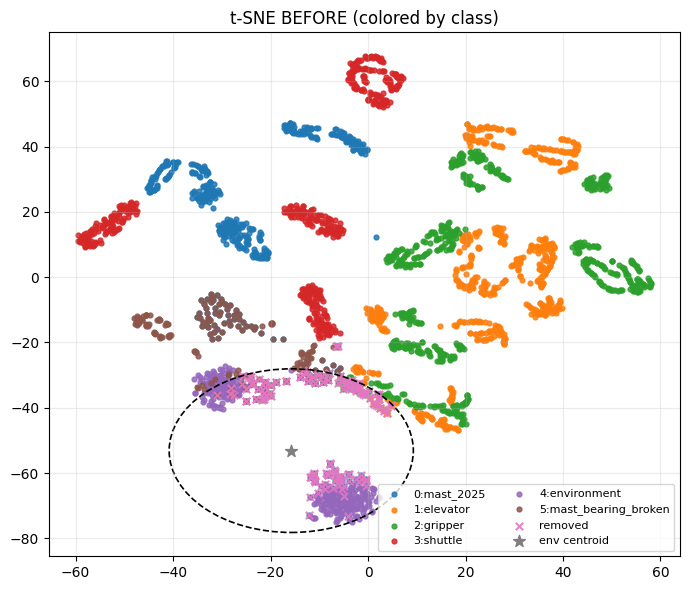

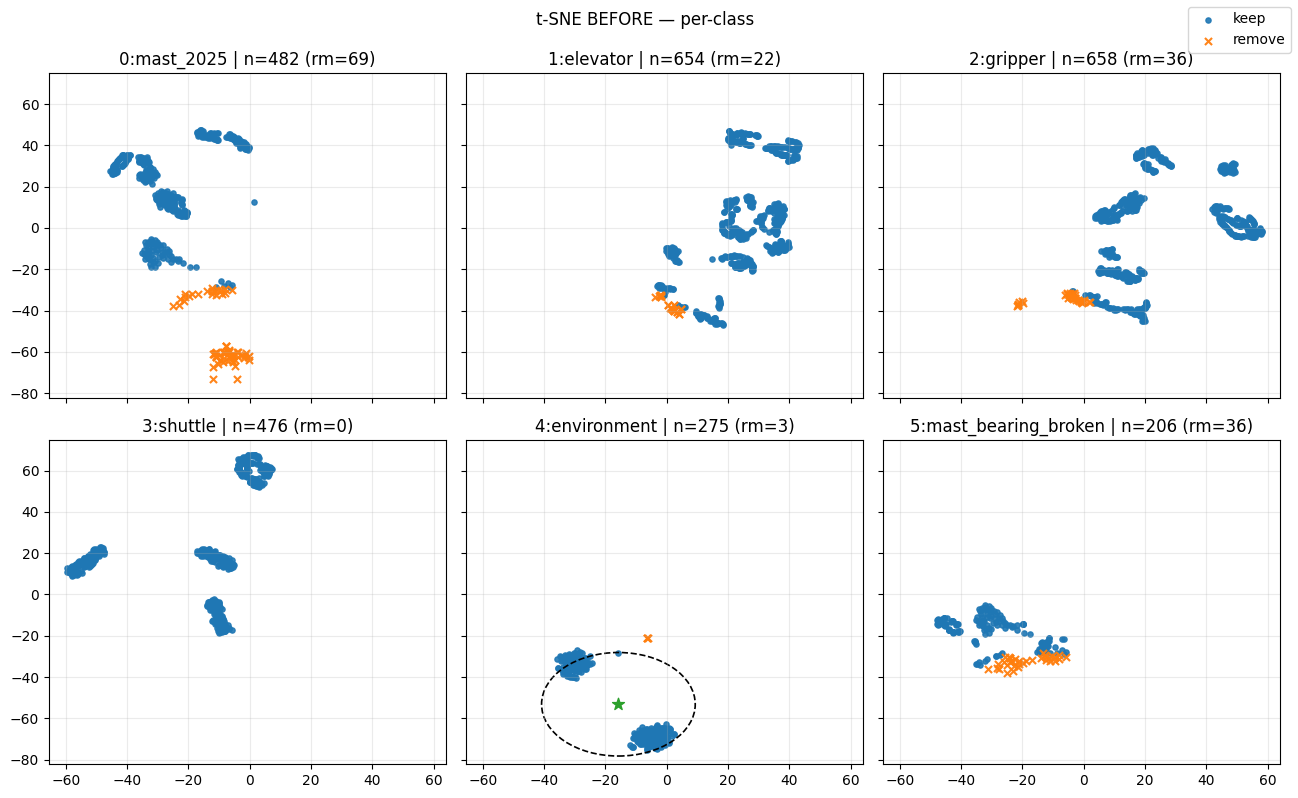

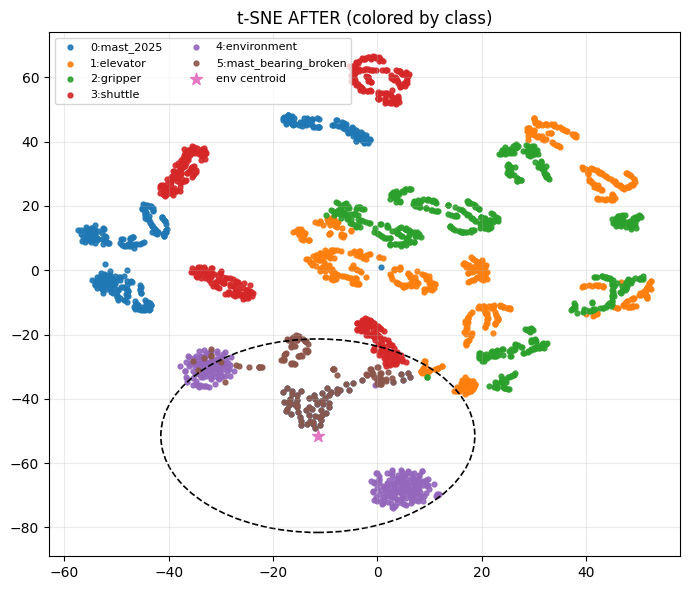

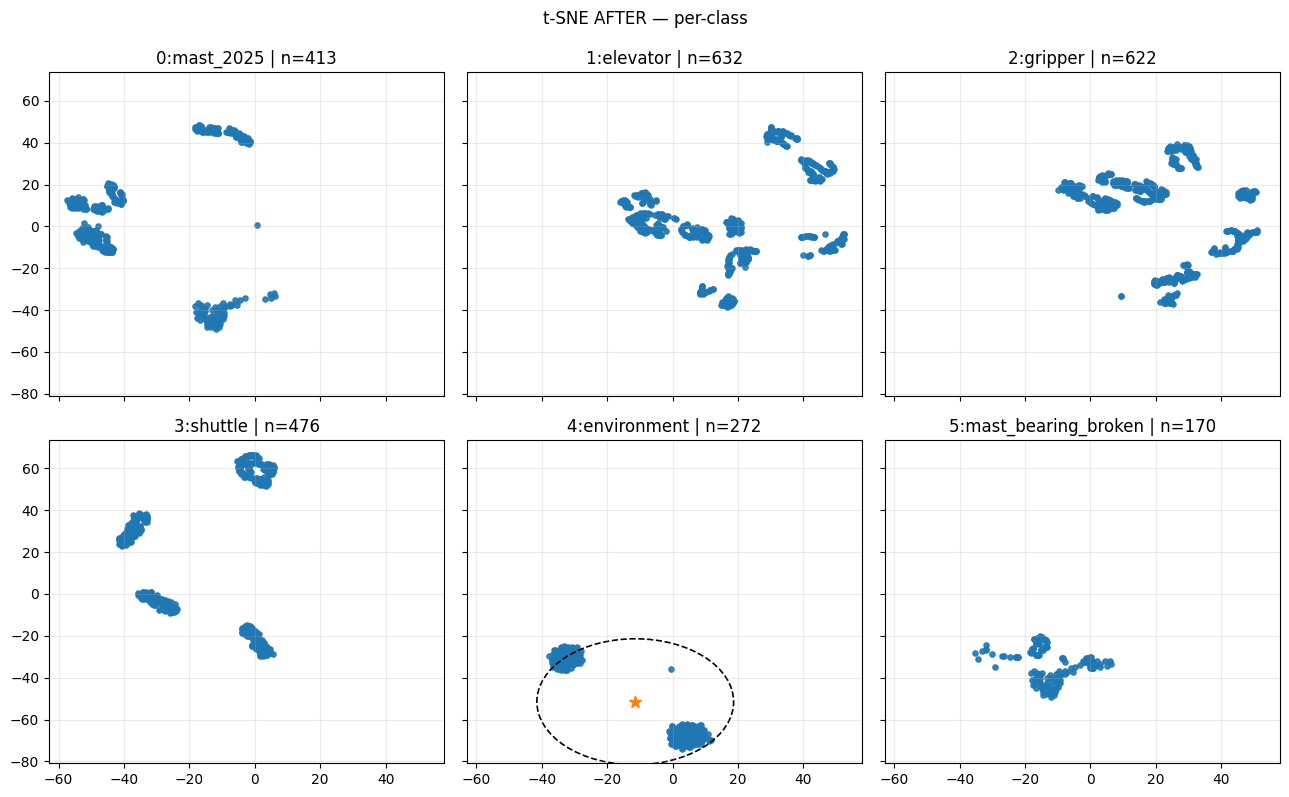

In [143]:
# ===================== t-SNE per-class plots (BEFORE & AFTER) =====================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ----- helper -----
def _grid_rc(n):
    # จัด layout เป็นสี่เหลี่ยมจัตุรัสใกล้เคียง
    r = int(np.floor(np.sqrt(n)))
    c = int(np.ceil(n / r))
    return r, c

def _label_name(cls):
    # ดึงชื่อจาก PATTERNS ถ้ามี (เช่น 'mast_bearing_broken_*')
    try:
        raw = PATTERNS[int(cls)]
        name = raw.replace('_*.wav', '').replace('*.wav', '')
        return name
    except Exception:
        return str(cls)

# ---------- Combined plot (BEFORE): color ตามคลาส ----------
classes_before = np.unique(y)
plt.figure(figsize=(7,6))
for cls in classes_before:
    idx = (y == cls)
    plt.scatter(Z[idx,0], Z[idx,1], s=12, alpha=0.85, label=f"{int(cls)}:{_label_name(cls)}")
# ไฮไลท์จุดที่ถูกลบ (ทุกคลาส) เป็นเครื่องหมาย x
plt.scatter(Z[remove_mask,0], Z[remove_mask,1], s=28, marker="x", alpha=0.9, label="removed")
# วงกลม environment (ก่อนลบ)
if np.any(y == ENVIRONMENT_CLASS) and np.isfinite(R_env):
    from matplotlib.patches import Circle
    plt.scatter([env_centroid[0]], [env_centroid[1]], s=80, marker="*", label="env centroid")
    plt.gca().add_patch(Circle(env_centroid, R_env, fill=False, linewidth=1.2, linestyle="--"))
plt.title("t-SNE BEFORE (colored by class)")
plt.grid(True, alpha=0.25)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# ---------- Small-multiples (BEFORE): หนึ่ง subplot ต่อคลาส ----------
r, c = _grid_rc(len(classes_before))
xpad = (Z[:,0].max() - Z[:,0].min()) * 0.05
ypad = (Z[:,1].max() - Z[:,1].min()) * 0.05
xlim = (Z[:,0].min() - xpad, Z[:,0].max() + xpad)
ylim = (Z[:,1].min() - ypad, Z[:,1].max() + ypad)

fig, axes = plt.subplots(r, c, figsize=(4*c+1, 4*r), sharex=True, sharey=True)
axes = np.array(axes).reshape(-1)
for k, cls in enumerate(classes_before):
    ax = axes[k]
    idx_all = (y == cls)
    idx_keep = idx_all & (~remove_mask)
    idx_rm   = idx_all & remove_mask
    ax.scatter(Z[idx_keep,0], Z[idx_keep,1], s=14, alpha=0.9, label="keep")
    ax.scatter(Z[idx_rm,0],   Z[idx_rm,1],   s=26, alpha=0.95, marker="x", label="remove")
    if cls == ENVIRONMENT_CLASS and np.isfinite(R_env):
        from matplotlib.patches import Circle
        ax.scatter([env_centroid[0]], [env_centroid[1]], s=80, marker="*", label="env centroid")
        ax.add_patch(Circle(env_centroid, R_env, fill=False, linewidth=1.2, linestyle="--"))
    ax.set_title(f"{int(cls)}:{_label_name(cls)} | n={idx_all.sum()} (rm={idx_rm.sum()})")
    ax.grid(True, alpha=0.25)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)

# ซ่อนแกนที่เกิน
for j in range(k+1, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
fig.suptitle("t-SNE BEFORE — per-class", y=0.99)
plt.tight_layout()
plt.show()

# ---------- Recompute t-SNE AFTER (บนข้อมูลที่คงไว้) ----------
Xn_keep = scaler_tsne.transform(X_clean)
perplexity_after = int(np.clip(Xn_keep.shape[0] // 50, 5, 30))
tsne_after = TSNE(n_components=2, init="pca", learning_rate="auto",
                  perplexity=perplexity_after, random_state=1337)
Z_after = tsne_after.fit_transform(Xn_keep)

# environment centroid/radius "หลังลบ" (เพื่อแสดงในกราฟ AFTER)
classes_after = np.unique(y_clean)
is_env_after = (y_clean == ENVIRONMENT_CLASS)
if np.any(is_env_after):
    Ze_after = Z_after[is_env_after]
    env_centroid_after = Ze_after.mean(axis=0)
    # ใช้ quantile เดิม (R_ENV_QUANTILE) เพื่อให้เทียบได้
    dist_env_after = np.linalg.norm(Ze_after - env_centroid_after, axis=1)
    try:
        R_env_after = np.quantile(dist_env_after, R_ENV_QUANTILE)
    except NameError:
        R_env_after = np.quantile(dist_env_after, 0.90)
else:
    env_centroid_after = np.array([np.nan, np.nan])
    R_env_after = np.nan

# ---------- Combined plot (AFTER) ----------
plt.figure(figsize=(7,6))
for cls in classes_after:
    idx = (y_clean == cls)
    plt.scatter(Z_after[idx,0], Z_after[idx,1], s=12, alpha=0.9, label=f"{int(cls)}:{_label_name(cls)}")
if np.any(is_env_after) and np.isfinite(R_env_after):
    from matplotlib.patches import Circle
    plt.scatter([env_centroid_after[0]], [env_centroid_after[1]], s=80, marker="*", label="env centroid")
    plt.gca().add_patch(Circle(env_centroid_after, R_env_after, fill=False, linewidth=1.2, linestyle="--"))
plt.title("t-SNE AFTER (colored by class)")
plt.grid(True, alpha=0.25)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

# ---------- Small-multiples (AFTER) ----------
r2, c2 = _grid_rc(len(classes_after))
xpad2 = (Z_after[:,0].max() - Z_after[:,0].min()) * 0.05
ypad2 = (Z_after[:,1].max() - Z_after[:,1].min()) * 0.05
xlim2 = (Z_after[:,0].min() - xpad2, Z_after[:,0].max() + xpad2)
ylim2 = (Z_after[:,1].min() - ypad2, Z_after[:,1].max() + ypad2)

fig2, axes2 = plt.subplots(r2, c2, figsize=(4*c2+1, 4*r2), sharex=True, sharey=True)
axes2 = np.array(axes2).reshape(-1)
for k, cls in enumerate(classes_after):
    ax = axes2[k]
    idx = (y_clean == cls)
    ax.scatter(Z_after[idx,0], Z_after[idx,1], s=14, alpha=0.9)
    if cls == ENVIRONMENT_CLASS and np.isfinite(R_env_after):
        from matplotlib.patches import Circle
        ax.scatter([env_centroid_after[0]], [env_centroid_after[1]], s=80, marker="*", label="env centroid")
        ax.add_patch(Circle(env_centroid_after, R_env_after, fill=False, linewidth=1.2, linestyle="--"))
    ax.set_title(f"{int(cls)}:{_label_name(cls)} | n={idx.sum()}")
    ax.grid(True, alpha=0.25)
    ax.set_xlim(*xlim2); ax.set_ylim(*ylim2)

for j in range(k+1, len(axes2)):
    axes2[j].axis("off")

handles2, labels2 = axes2[0].get_legend_handles_labels()
if handles2:
    fig2.legend(handles2, labels2, loc="upper right")
fig2.suptitle("t-SNE AFTER — per-class", y=0.99)
plt.tight_layout()
plt.show()


In [146]:
# ---------- Class count BEFORE / AFTER ----------
def _counts_str(a):
    if a.size == 0: return "<empty>"
    u, c = np.unique(a, return_counts=True)
    return ", ".join(f"{int(k)}:{int(v)}" for k, v in zip(u, c))

n_cls_before = len(np.unique(y))
n_cls_after  = len(np.unique(y_clean))
print(f"Classes BEFORE: {n_cls_before} | counts: {_counts_str(y)}")
print(f"Classes AFTER : {n_cls_after}  | counts: {_counts_str(y_clean)}")

removed = sorted(set(np.unique(y)) - set(np.unique(y_clean)))
if removed:
    print("Classes removed after cleaning:", removed)


Classes BEFORE: 6 | counts: 0:482, 1:654, 2:658, 3:476, 4:275, 5:206
Classes AFTER : 6  | counts: 0:413, 1:632, 2:622, 3:476, 4:272, 5:170


Train: (2068, 120), Test: (517, 120), Classes: 6 -> ['mast_2025', 'elevator', 'gripper', 'shuttle', 'environment', 'mast_bearing_broken']

[LogReg] Acc=0.9091 | F1-macro=0.8845
                     precision    recall  f1-score   support

          mast_2025      0.852     0.863     0.857        80
           elevator      0.943     0.906     0.924       128
            gripper      0.918     0.932     0.925       132
            shuttle      0.979     0.968     0.974        95
        environment      0.959     1.000     0.979        47
mast_bearing_broken      0.639     0.657     0.648        35

           accuracy                          0.909       517
          macro avg      0.882     0.888     0.884       517
       weighted avg      0.910     0.909     0.909       517



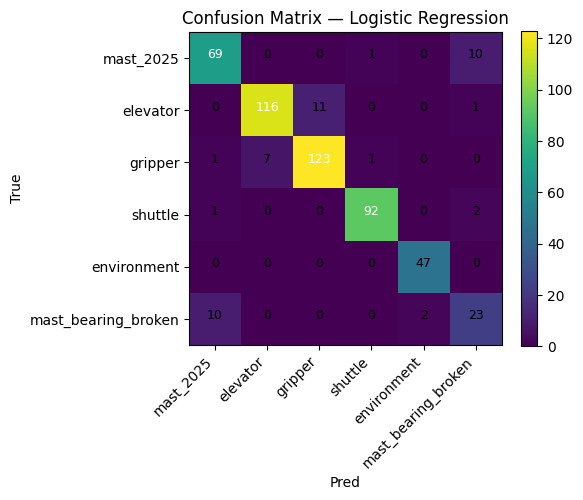


[LightGBM] Acc=0.9439 | F1-macro=0.9059
                     precision    recall  f1-score   support

          mast_2025      0.845     0.887     0.866        80
           elevator      1.000     0.969     0.984       128
            gripper      0.978     0.992     0.985       132
            shuttle      1.000     0.989     0.995        95
        environment      0.959     1.000     0.979        47
mast_bearing_broken      0.656     0.600     0.627        35

           accuracy                          0.944       517
          macro avg      0.906     0.906     0.906       517
       weighted avg      0.943     0.944     0.943       517



c:\Users\noppa\miniconda3\envs\fd_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


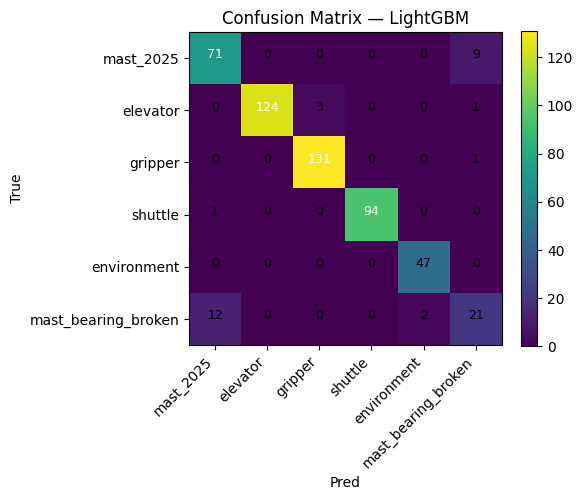


== Summary ==
LogReg  : Acc=0.9091 | F1m=0.8845
LightGBM: Acc=0.9439 | F1m=0.9059
Saved models: "model_logreg.pkl", "model_lightgbm.pkl"


In [150]:
# ===================== Train & Evaluate: Logistic Regression vs LightGBM =====================
import numpy as np, joblib, matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ใช้ชุด cleaned ถ้ามี ไม่งั้น fallback เป็นชุดเดิม
X_ = X_clean if 'X_clean' in globals() else X
y_ = y_clean if 'y_clean' in globals() else y
groups_ = groups_clean if 'groups_clean' in globals() else groups
RAND = 1337

# ------------------ split แบบ group-aware ------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RAND)
tr_idx, te_idx = next(gss.split(X_, y_, groups_))
Xtr, Xte = X_[tr_idx], X_[te_idx]
ytr, yte = y_[tr_idx], y_[te_idx]

# ------------------ helper ------------------
def class_names_from_patterns(labels):
    names = {}
    for k in np.unique(labels):
        try:
            nm = PATTERNS[int(k)].replace('_*.wav','').replace('*.wav','').replace('.wav','')
        except Exception:
            nm = str(int(k))
        names[int(k)] = nm
    return names

label_names = class_names_from_patterns(y_)
classes_sorted = sorted(np.unique(y_))
display_names = [label_names[c] for c in classes_sorted]

def plot_cm(cm, title):
    import itertools
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.colorbar()
    tick = np.arange(len(classes_sorted))
    plt.xticks(tick, display_names, rotation=45, ha='right')
    plt.yticks(tick, display_names)
    # ใส่ตัวเลข
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=9)
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout()
    plt.show()

print(f"Train: {Xtr.shape}, Test: {Xte.shape}, Classes: {len(classes_sorted)} -> {display_names}")

# ------------------ 1) Logistic Regression (with StandardScaler) ------------------
lr = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(
        max_iter=2000, solver="saga", n_jobs=-1,
        class_weight="balanced", random_state=RAND
    )
)
lr.fit(Xtr, ytr)
pred_lr = lr.predict(Xte)

acc_lr = accuracy_score(yte, pred_lr)
f1m_lr = f1_score(yte, pred_lr, average="macro")
print(f"\n[LogReg] Acc={acc_lr:.4f} | F1-macro={f1m_lr:.4f}")
print(classification_report(yte, pred_lr, labels=classes_sorted, target_names=display_names, digits=3))
cm_lr = confusion_matrix(yte, pred_lr, labels=classes_sorted)
plot_cm(cm_lr, "Confusion Matrix — Logistic Regression")

# ------------------ 2) LightGBM ------------------
try:
    import lightgbm as lgb
except ImportError as e:
    raise ImportError("ต้องติดตั้งแพ็กเกจ lightgbm ก่อน (pip install lightgbm)") from e

lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(classes_sorted),
    n_estimators=600,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight="balanced",
    random_state=RAND
)
# ใช้ early stopping บนชุดทดสอบเพื่อกันโอเวอร์ฟิต
lgbm.fit(
    Xtr, ytr,
    eval_set=[(Xte, yte)],
)
pred_lgb = lgbm.predict(Xte)

acc_lgb = accuracy_score(yte, pred_lgb)
f1m_lgb = f1_score(yte, pred_lgb, average="macro")
print(f"\n[LightGBM] Acc={acc_lgb:.4f} | F1-macro={f1m_lgb:.4f}")
print(classification_report(yte, pred_lgb, labels=classes_sorted, target_names=display_names, digits=3))
cm_lgb = confusion_matrix(yte, pred_lgb, labels=classes_sorted)
plot_cm(cm_lgb, "Confusion Matrix — LightGBM")

# ------------------ สรุปเปรียบเทียบ & เซฟโมเดลเทรนเต็มชุด ------------------
print("\n== Summary ==")
print(f"LogReg  : Acc={acc_lr:.4f} | F1m={f1m_lr:.4f}")
print(f"LightGBM: Acc={acc_lgb:.4f} | F1m={f1m_lgb:.4f}")

# เทรนใหม่บน "ชุดข้อมูลทั้งหมด" เพื่อใช้งานจริง แล้วเซฟ
lr.fit(X_, y_)
lgbm_full = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(classes_sorted),
    n_estimators=max(100, lgbm.best_iteration_ or 100),
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight="balanced",
    random_state=RAND
).fit(X_, y_)

joblib.dump(lr, "model_logreg.pkl")
joblib.dump(lgbm_full, "model_lightgbm.pkl")
print('Saved models: "model_logreg.pkl", "model_lightgbm.pkl"')
